
# Convolutional Neural Network



## 1. Load Data


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))


Training set has 60000 instances
Validation set has 10000 instances


### Visualize Data

Shirt  Sandal  T-shirt/top  Shirt


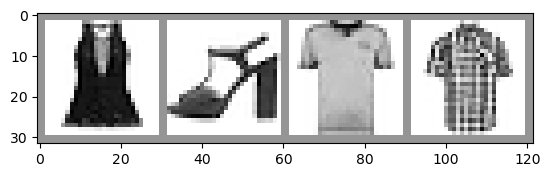

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

## 2. Create a Convolutional Neural Network


In [6]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

## 3. Cross Entropy Loss


In [7]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.0011, 0.6053, 0.4971, 0.7190, 0.1326, 0.5513, 0.7454, 0.5425, 0.1713,
         0.2643],
        [0.6775, 0.4560, 0.0770, 0.8561, 0.3650, 0.6625, 0.4342, 0.6896, 0.6274,
         0.8134],
        [0.6496, 0.1403, 0.3247, 0.3341, 0.1386, 0.4153, 0.8690, 0.5408, 0.9712,
         0.9777],
        [0.0148, 0.1606, 0.1656, 0.5708, 0.9221, 0.6995, 0.5179, 0.3618, 0.6097,
         0.7591]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.346862554550171


## 4. Optimizer

In [8]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 5. Train the network
### Per-Epoch Activity


In [10]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            # tb_x = epoch_index * len(training_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

### Multiple Epochs

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    # writer.add_scalars('Training vs. Validation Loss',
    #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                 epoch_number + 1)
    # writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.8407556702792645
  batch 2000 loss: 0.8749795267991721
  batch 3000 loss: 0.7324666945952922
  batch 4000 loss: 0.6564940435905009
  batch 5000 loss: 0.6077160715796054
  batch 6000 loss: 0.5440358044463209
  batch 7000 loss: 0.5435046407094923
  batch 8000 loss: 0.5174626575896982
  batch 9000 loss: 0.5091280344920233
  batch 10000 loss: 0.47756998491799457
  batch 11000 loss: 0.4691865077639231
  batch 12000 loss: 0.47263793799863196
  batch 13000 loss: 0.462347135720076
  batch 14000 loss: 0.42011859886767344
  batch 15000 loss: 0.413149175106133
LOSS train 0.413149175106133 valid 0.4328720271587372
EPOCH 2:
  batch 1000 loss: 0.396211026969715
  batch 2000 loss: 0.3784739063198795
  batch 3000 loss: 0.3893904087402625
  batch 4000 loss: 0.35922142141198854
  batch 5000 loss: 0.36765356952825096
  batch 6000 loss: 0.38763769240514373
  batch 7000 loss: 0.3761661134462338
  batch 8000 loss: 0.3816400774320355
  batch 9000 loss: 0.3696248953506001
  batch

## 5. Evaluate the Convolutional Neural Network Model


GroundTruth:  Ankle Boot  Pullover  Trouser  Trouser
Predicted:  Ankle Boot  Pullover  Trouser  Trouser


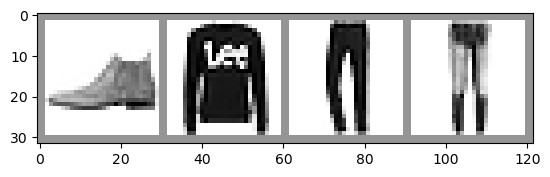

In [17]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('GroundTruth: ', '  '.join(classes[labels[j]] for j in range(4)))

val_outputs = model(images)
max_val, max_ids = torch.max(val_outputs, dim=1)
print('Predicted: ', '  '.join(classes[max_ids[j]] for j in range(4)))


### Classification Accuracy

In [23]:
correct_num = 0
total_num = 0
# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():  # zero the parameter gradients
    for images, labels in validation_loader:
        outputs = model(images)  # predict images classes
        _, max_ids = torch.max(outputs.data, dim=1)  # the class with the highest energy is what we choose as prediction
        total_num += labels.size(0)
        correct_num += (max_ids == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct_num // total_num} %')

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():  # again no gradients needed
    for images, labels in validation_loader:
        outputs = model(images)
        _, max_ids = torch.max(outputs.data, dim=1)  # the class with the highest energy is what we choose as prediction
        # collect the correct predictions for each class
        for label, prediction in zip(labels, max_ids):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the 10000 test images: 89 %
Accuracy for class: T-shirt/top is 85.1 %
Accuracy for class: Trouser is 97.7 %
Accuracy for class: Pullover is 83.3 %
Accuracy for class: Dress is 90.2 %
Accuracy for class: Coat  is 88.9 %
Accuracy for class: Sandal is 97.0 %
Accuracy for class: Shirt is 60.7 %
Accuracy for class: Sneaker is 98.0 %
Accuracy for class: Bag   is 97.3 %
Accuracy for class: Ankle Boot is 93.6 %


## 6. Further Improvements

### Dataloader with Larger Batch Size

In [20]:
training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)


### Updated Model with GPU Support

In [34]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class WearingClassifier(nn.Module):
    def __init__(self):
        super(WearingClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (28 - 5 + 2 * 0) / 2 + 1 = 12.5
        x = F.relu(self.conv2(x))  # (12 - 5 + 2 * 0) / 1 + 1 = 8
        x = F.relu(self.conv3(x))  # (8 - 3 + 2 * 0) / 1 + 1 = 6
        x = F.relu(self.conv3(x))  # (6 - 3 + 2 * 0) / 1 + 1 = 4
        x = x.view(-1, 32 * 4 * 4)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = WearingClassifier().to(device)
print(model)

Using cuda device
WearingClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [35]:
images, labels = next(iter(validation_loader))
X, y = images.to(device), labels.to(device)
print(model(X))

tensor([[ 0.0017, -0.0499, -0.0785,  0.0666,  0.0711,  0.0530,  0.0244, -0.0432,
         -0.1054,  0.0649],
        [ 0.0043, -0.0494, -0.0805,  0.0670,  0.0714,  0.0567,  0.0217, -0.0434,
         -0.1096,  0.0641],
        [ 0.0062, -0.0520, -0.0807,  0.0649,  0.0716,  0.0549,  0.0205, -0.0436,
         -0.1081,  0.0670],
        [ 0.0047, -0.0527, -0.0799,  0.0650,  0.0692,  0.0527,  0.0238, -0.0449,
         -0.1062,  0.0662],
        [ 0.0027, -0.0518, -0.0787,  0.0653,  0.0715,  0.0533,  0.0226, -0.0439,
         -0.1052,  0.0659],
        [ 0.0038, -0.0543, -0.0777,  0.0666,  0.0714,  0.0504,  0.0235, -0.0446,
         -0.1051,  0.0677],
        [ 0.0019, -0.0521, -0.0775,  0.0665,  0.0696,  0.0503,  0.0256, -0.0458,
         -0.1050,  0.0667],
        [ 0.0028, -0.0510, -0.0786,  0.0661,  0.0708,  0.0524,  0.0237, -0.0435,
         -0.1055,  0.0665],
        [ 0.0034, -0.0523, -0.0774,  0.0677,  0.0707,  0.0489,  0.0256, -0.0430,
         -0.1049,  0.0657],
        [ 0.0032, -